# Environmental Sound Classification

## Introduction

This project is about classifying environment sounds using an appropraite deep learning algorithm. This dataset contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: air_conditioner, car_horn, children_playing, dog_bark, drilling, enginge_idling, gun_shot, jackhammer, siren, and street_music. The classes are drawn from the urban sound taxonomy. For a detailed description of the dataset and how it was compiled please refer to the paper(link is given below). And a CSV file containing metadata about each sound clip is also provided. 

Reference:
http://www.justinsalamon.com/uploads/4/3/9/4/4394963/salamon_urbansound_acmmm14.pdf


### Load the imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import librosa
import librosa.display
import IPython.display as ipd
import codecs, json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D,LSTM,Conv2D,MaxPooling1D,MaxPooling2D,Dense,Flatten,Dropout,BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')


Bad key text.latex.preview in file /home/msc1/anaconda3/envs/Env-7146COMP/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /home/msc1/anaconda3/envs/Env-7146COMP/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /home/msc1/anaconda3/envs/Env-7146COMP/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95 

### Load the data¶

In [2]:
df = pd.read_csv('./UrbanSound8K.csv')
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


## Exploratory Data Analysis

There are 8 columns in the CSV file. The lenght of the dataframe is 8732.

In [3]:
df.shape

(8732, 8)

The slice_file_name column is the name of the audio files. There are totally 8732 audio files.

In [4]:
df['slice_file_name'].value_counts()

66623-4-0-0.wav      1
178261-7-3-3.wav     1
101848-9-0-0.wav     1
67049-3-0-2.wav      1
156869-8-0-5.wav     1
                    ..
155238-2-0-75.wav    1
159738-8-0-17.wav    1
178260-7-5-0.wav     1
144007-5-1-8.wav     1
203913-8-0-12.wav    1
Name: slice_file_name, Length: 8732, dtype: int64

The column fsID is the Freesound ID of the recording from which this excerpt (slice) is taken. They are totally 1297 in lenght. The audio clips have been sliced from these original recordings.

In [5]:
df['fsID'].value_counts()

24347     100
180937     95
72259      73
203929     72
62837      66
         ... 
196073      1
196065      1
196057      1
138465      1
160093      1
Name: fsID, Length: 1297, dtype: int64

The start and end columns are the start and end of the slice from the original sound recording respectively.

The salience column is the salience rating of the sound. 1 = foreground, 2 = background.

In [6]:
df['salience'].value_counts()

1    5702
2    3030
Name: salience, dtype: int64

The fold column contains the folder number (1-10) with their corresponding audio files. All the folders have around 800 to 900 audio files.

In [7]:
df['fold'].value_counts()

4     990
5     936
3     925
2     888
1     873
7     838
10    837
6     823
9     816
8     806
Name: fold, dtype: int64

The below code list out the folders from the audio directory in the project directory.

In [8]:
print(os.listdir('./audio'))

['fold1', 'fold6', 'fold5', 'fold9', 'fold4', 'fold8', 'fold7', 'fold10', 'fold2', 'fold3']


Let's check for class imbalance, the below code shows number of each classes. Almost all classes are 1000 in numbers except siren, car horn and gunshot.

In [9]:
df['class'].value_counts()

children_playing    1000
jackhammer          1000
drilling            1000
air_conditioner     1000
engine_idling       1000
dog_bark            1000
street_music        1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

The columns class and classID contains the 10 classes and their corresponding classIDs. The below code groups by the two columns, filters out the unique and show the class names and their corresponding IDs.

In [10]:
cls_df = df.groupby(['class', 'classID']).nunique()
cls_df.iloc[:, :0]

,
class,classID
air_conditioner,0
car_horn,1
children_playing,2
dog_bark,3
drilling,4
engine_idling,5
gun_shot,6
jackhammer,7
siren,8


Let's take one sample from each class and visualise the waveform. I want the sound clips in which the salaience feature of the class is 1, meaning, the sound should be in the foreground and not background. But, there are 8732 files distributed in 10 folders. It is a time-consuming process to manually search and select 10 different classes with salience 1. So, I will write a script in Python to loop through the whole dataframe and select 10 unique classes with salience 1. As the whole idea of Artifial Intelligence is to automate tasks and overcome manual work.

In [11]:
unique_list = [] # create an empty list to hold unique class names
for row in range(len(df)): # loop through the dataframe
    if len(unique_list) == 10: # if lenght of unique_list is 10, then break out, we got our 10 classes
        break
    if df.iloc[row,][4] == 1: # check if salience is 1
        cls_name = df.iloc[row,][7] # set the class name
        if cls_name not in unique_list: # check if class name is not present in the list
            unique_list.append(cls_name) # append the unique class name in the list
            print(df.iloc[row,]) # print the required rows in series format

slice_file_name    100032-3-0-0.wav
fsID                         100032
start                           0.0
end                        0.317551
salience                          1
fold                              5
classID                           3
class                      dog_bark
Name: 0, dtype: object
slice_file_name    100263-2-0-117.wav
fsID                           100263
start                            58.5
end                              62.5
salience                            1
fold                                5
classID                             2
class                children_playing
Name: 1, dtype: object
slice_file_name    100852-0-0-0.wav
fsID                         100852
start                           0.0
end                             4.0
salience                          1
fold                              5
classID                           0
class               air_conditioner
Name: 22, dtype: object
slice_file_name    101848-9-0-0.wav
fsID          

The above output gives us the filenames of 10 different classes with salience 1. It also gives the folder number. Now, the sound file can be easily processed. I will use librosa to plot the waveforms of these sound clips.

Along with waveform plots, I will also add the audio clip feature using IPython display. The sound can be heard and the corresponding waveform can be seen.

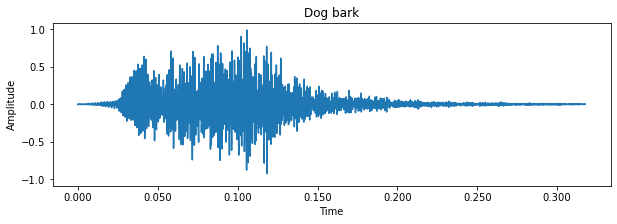

In [12]:
file_path = './audio/fold5/100032-3-0-0.wav'
data, sampling_rate = librosa.load(file_path)
plt.figure(figsize=(10, 3))
plt.title(label='Dog bark')
plt.xlabel('Time')
plt.ylabel('Amplitude')
librosa.display.waveshow(data, sr=sampling_rate)
ipd.Audio(data, rate=sampling_rate)

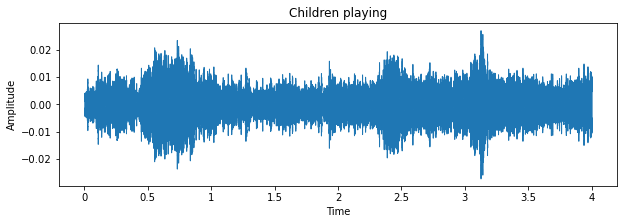

In [13]:
file_path = './audio/fold5/100263-2-0-117.wav'
data, sampling_rate = librosa.load(file_path)
plt.figure(figsize=(10, 3))
plt.title(label='Children playing')
plt.xlabel('Time')
plt.ylabel('Amplitude')
librosa.display.waveshow(data, sr=sampling_rate)
ipd.Audio(data, rate=sampling_rate)

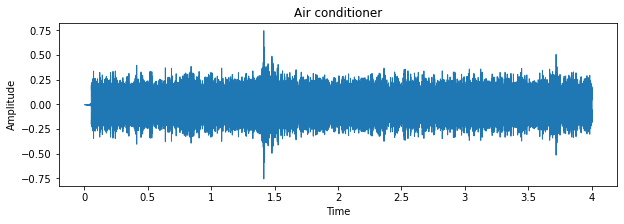

In [14]:
file_path = './audio/fold5/100852-0-0-0.wav'
data, sampling_rate = librosa.load(file_path)
plt.figure(figsize=(10, 3))
plt.title(label='Air conditioner')
plt.xlabel('Time')
plt.ylabel('Amplitude')
librosa.display.waveshow(data, sr=sampling_rate)
ipd.Audio(data, rate=sampling_rate)

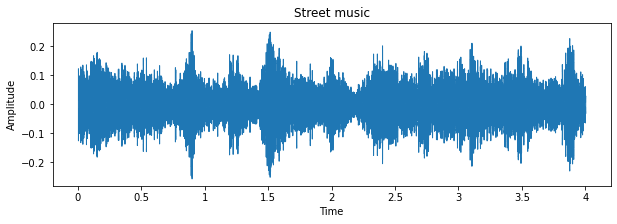

In [15]:
file_path = './audio/fold7/101848-9-0-0.wav'
data, sampling_rate = librosa.load(file_path)
plt.figure(figsize=(10, 3))
plt.title(label='Street music')
plt.xlabel('Time')
plt.ylabel('Amplitude')
librosa.display.waveshow(data, sr=sampling_rate)
ipd.Audio(data, rate=sampling_rate)

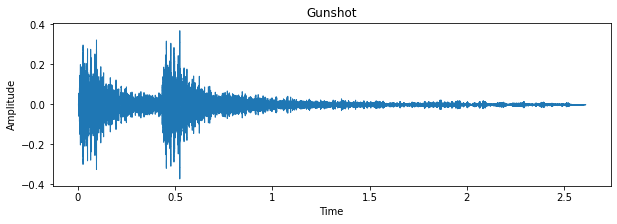

In [16]:
file_path = './audio/fold1/102305-6-0-0.wav'
data, sampling_rate = librosa.load(file_path)
plt.figure(figsize=(10, 3))
plt.title(label='Gunshot')
plt.xlabel('Time')
plt.ylabel('Amplitude')
librosa.display.waveshow(data, sr=sampling_rate)
ipd.Audio(data, rate=sampling_rate)

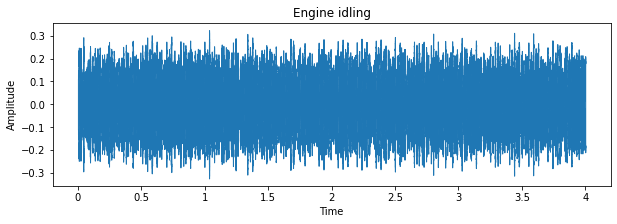

In [17]:
file_path = './audio/fold10/102857-5-0-0.wav'
data, sampling_rate = librosa.load(file_path)
plt.figure(figsize=(10, 3))
plt.title(label='Engine idling')
plt.xlabel('Time')
plt.ylabel('Amplitude')
librosa.display.waveshow(data, sr=sampling_rate)
ipd.Audio(data, rate=sampling_rate)

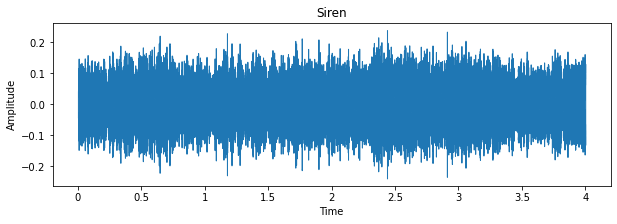

In [18]:
file_path = './audio/fold2/102871-8-0-0.wav'
data, sampling_rate = librosa.load(file_path)
plt.figure(figsize=(10, 3))
plt.title(label='Siren')
plt.xlabel('Time')
plt.ylabel('Amplitude')
librosa.display.waveshow(data, sr=sampling_rate)
ipd.Audio(data, rate=sampling_rate)

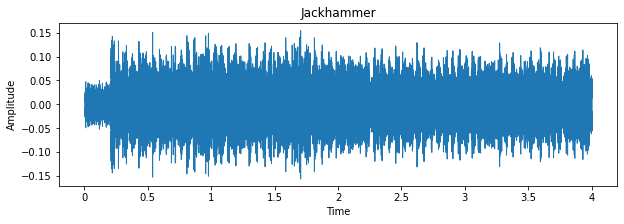

In [19]:
file_path = './audio/fold1/103074-7-0-0.wav'
data, sampling_rate = librosa.load(file_path)
plt.figure(figsize=(10, 3))
plt.title(label='Jackhammer')
plt.xlabel('Time')
plt.ylabel('Amplitude')
librosa.display.waveshow(data, sr=sampling_rate)
ipd.Audio(data, rate=sampling_rate)

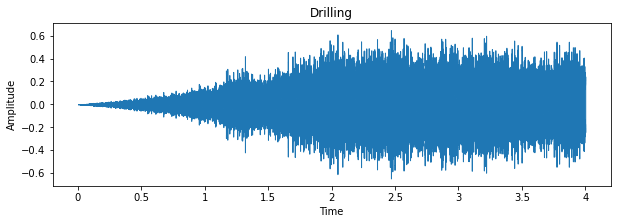

In [20]:
file_path = './audio/fold3/103199-4-0-0.wav'
data, sampling_rate = librosa.load(file_path)
plt.figure(figsize=(10, 3))
plt.title(label='Drilling')
plt.xlabel('Time')
plt.ylabel('Amplitude')
librosa.display.waveshow(data, sr=sampling_rate)
ipd.Audio(data, rate=sampling_rate)

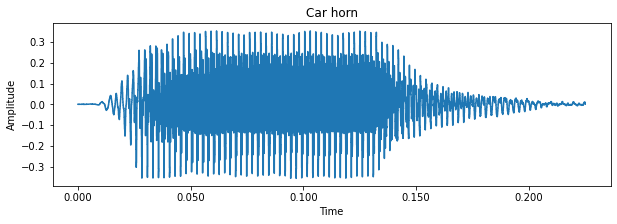

In [21]:
file_path = './audio/fold3/118070-1-0-0.wav'
data, sampling_rate = librosa.load(file_path)
plt.figure(figsize=(10, 3))
plt.title(label='Car horn')
plt.xlabel('Time')
plt.ylabel('Amplitude')
librosa.display.waveshow(data, sr=sampling_rate)
ipd.Audio(data, rate=sampling_rate)

From the above sound clip and waveforms the differences in the sounds of different classes can be heard and seen. It is intresting too see how the waveform amplitude of different sounds differs from each other.

## Data Pre-processing

The neural network cannot be trained directly with the sound data. The features has to be extracted and then used for training. These features are in the form of numpy array. There are many features that can be extracted from sound data, but the two most important are Spectrogram and MFCC. These features are used for training neural networks. Anyone can be used, but using a combination of these two produces a better result.

### Spectrogram

A spectrogram is a visual way of representing the sound data. It displays the signal strength at different frequencies of a waveform. It is usually depicted as a heatmap. Let's take one sample audio, extract spectrogram feature and visualize it. I will use dog barking sound sample. 

First the data has to be converted to Short Term Fourier Transform (STFT). In this transformation the amplitude of the given frequency is known at a given time. The specshow function is used to display the spectrogram.

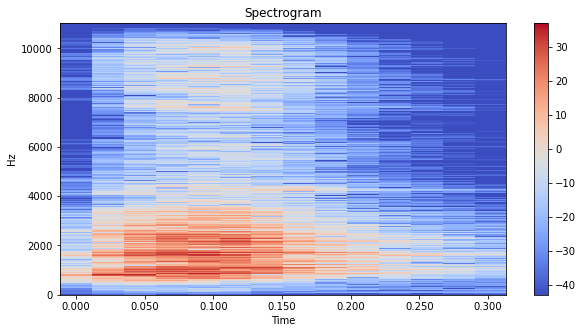

In [22]:
file_path = './audio/fold5/100032-3-0-0.wav'
data, sampling_rate = librosa.load(file_path)
# perform short term fourier transorm on the data
stft = librosa.stft(data)
# convert stft feature from amplitude to decibel absolute value
spec = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(10, 5))
# display spectrogram using librosa specshow function
librosa.display.specshow(spec, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.title(label='Spectrogram')
plt.colorbar()
plt.show()

It can be seen that the frequencies are at the bottom of the spectrum. Let's apply logarithm to improve distribution. 

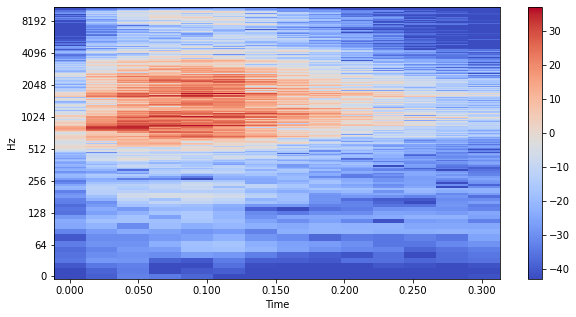

In [23]:
plt.figure(figsize=(10, 5))
librosa.display.specshow(spec, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

Below plot shows the melspectrogram of the data. It is a spectrogram where the frequencies are converted to mel scale.

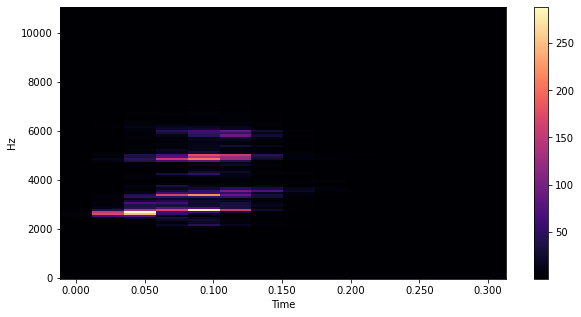

In [24]:
plt.figure(figsize=(10, 5))
spectro = librosa.feature.melspectrogram(data, sr=sampling_rate)
librosa.display.specshow(spectro, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.colorbar()
plt.show()

### Mel Frequency Cepstral Co-efficient (MFCC)

MFCC represents set of features that describe the overall shape of the spectral envelop. It models the characteristics of the human voice. MFCC is the most widely used and best feature to train any machine learning algorithm. I will use the same sound sample and visualize the MFCC feature.

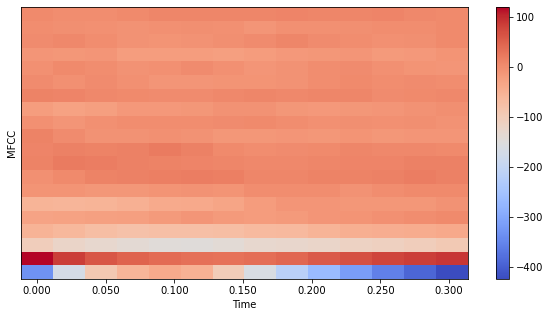

In [25]:
# use mfcc function to extract the feature
mfcc = librosa.feature.mfcc(data, sr=sampling_rate)
plt.figure(figsize=(10, 5))
# use specshow function to visualise mfcc
librosa.display.specshow(mfcc, sr=sampling_rate, x_axis='time')
plt.xlabel('Time')
plt.ylabel('MFCC')
plt.colorbar()
plt.show()

The x-axis is time displays the time and the y-axis displays MFCC coefficients. By default 20 coefficients are produced, but we can change this number as well.

### Create features and labels

The below script will loop through each audio file in 10 folders and extract Melspectrogram and MFCC. Both MFCC and Melspectrogram will be concatenated to form new features. In total 4 lists will be created with spectrogram features, MFCC features, new concatenated features, and list containing labels

In [26]:
def extract_feature(df):
    # dictionary with all list
    data_dict = {}
    # list with spectrogram features
    spec_features = []
    # list with mfcc features
    mfcc_features = []
    # list with combined features
    concat_features = []
    # label lists
    label_list = []

    for i in range(len(df)):
        # path of audio file
        file_path = './audio/fold' + str(df["fold"][i]) + '/' + df["slice_file_name"][i]
        # load audio file as numpy array
        audio_data, sampling_rate = librosa.load(file_path)

        # extract mel spectrogram
        spectro = librosa.feature.melspectrogram(audio_data, sr=sampling_rate)
        # averaging the values of spectrogram
        spectro = np.mean(spectro, axis=1)
        # append spectrogram features to the list
        spec_features.append(spectro)

        # extract mfcc
        mfcc = librosa.feature.mfcc(audio_data, sr=sampling_rate)
        # averaging the values of mfcc
        mfcc = np.mean(mfcc, axis=1)
        # append mfcc features to the list
        mfcc_features.append(mfcc)

        # concatenate the features of spectrogram and mfcc
        new_features = np.concatenate((spectro, mfcc), axis=0)
        # append combined features to the list
        concat_features.append(new_features)

        # append classID of the audio to the labels list
        label_list.append(df['classID'][i])

    # save all the lists to the dictionary
    data_dict = {
        'spec': spec_features,
        'mfcc': mfcc_features,
        'concat': concat_features,
        'label': label_list
    }
    # # save all the lists to the dictionary
    # data_dict = {
    #     'spec': spec_features,
    #     'mfcc': mfcc_features,
    #     'label': label_list
    # }
    # # save dictionary to json file
    # with open('data.json', 'w') as fp:
    #     json.dump(data, fp)

In [27]:
def extract_feature():
    # list with spectrogram features
    spec_list = []
    # list with mfcc features
    mfcc_list = []
    # list with concatenated features
    concat_list = []
    # label lists
    label_list = []

    for i in range(len(df)):
        # path of audio file
        file_path = './audio/fold' + str(df["fold"][i]) + '/' + df["slice_file_name"][i]
        # load audio file as numpy array
        audio_data, sampling_rate = librosa.load(file_path)

        # extract mel spectrogram
        spec = librosa.feature.melspectrogram(audio_data, sr=sampling_rate)
        #average column values of the spec array 
        spec = np.mean(spec, axis=1)
        # append spectrogram features to the list
        spec_list.append(spec)

        # extract mfcc
        mfcc = librosa.feature.mfcc(audio_data, sr=sampling_rate)
        #average column values of the mfcc array
        mfcc = np.mean(mfcc, axis=1)
        # append mfcc features to the list
        mfcc_list.append(mfcc)

        # concatenate the features of spectrogram and mfcc
        new_features = np.concatenate((spec, mfcc), axis=0)
        # append combined features to the list
        concat_list.append(new_features)
    
        # append classID of the audio to the labels list
        label_list.append(df['classID'][i])

    return spec_list, mfcc_list, concat_list, label_list

In [28]:
spec_list, mfcc_list, concat_list, label_list = extract_feature()

Covert the lists to numpy array so that keras can process it.

In [29]:
spec_arr = np.array(spec_list)
mfcc_arr = np.array(mfcc_list)
concat_arr = np.array(concat_list)
label_arr = np.array(label_list)

In [30]:
print(spec_arr.shape)
print(mfcc_arr.shape)
print(concat_arr.shape)

(8732, 128)
(8732, 20)
(8732, 148)


I will perform one hot encoding on the labels. Machine learning algorithms performs better with one hot encoded categorical data. I will use to_categorical function from keras utils.

In [31]:
from tensorflow.keras.utils import to_categorical

In [32]:
label_arr = to_categorical(label_arr)
label_arr.shape

(8732, 10)

First, I will try training with only MFCC. Because MFCC is most widely used and performs better than Melspectrogram with almost all machine learning algorithms. Then, i will try another training cycle with the combined features

The features and labels will be converted to training sets, validation sets, and testing sets. The method train_test_split from sklearn will be used.

In [33]:
from sklearn.model_selection import train_test_split

First the data will be converted to a bigger sets and test sets.

In [34]:
X, X_test, y, y_test = train_test_split(mfcc_arr, label_arr, test_size=0.1, random_state=12, stratify=label_arr)

The bigger set will be converted to train sets and validation sets.

In [35]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=21, stratify=y)

The shapes of the sets are printed below

In [36]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(7072, 20) (7072, 10)
(786, 20) (786, 10)
(874, 20) (874, 10)
